In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
# sns.set(style="dark")
sns.set(style="whitegrid")
sns.set_palette("Paired")
font_size = [8,10]
plt.rcParams.update({'font.size': font_size[0]})
colors = sns.color_palette("Paired",12)
color_idxs = [1,7,3] # ours, mppi, sac
linestyle = ['solid','solid','solid']
markers = ['','d','o']

In [3]:
def pull_max(d):
    _rew = None
    new_mean = []
    for m in d:
        if _rew is None:
            _rew = m
        else:
            if m > _rew:
                _rew = m
        new_mean.append(_rew)
    return new_mean

def process_data(env_path, N=20, best=False):
    data = []
    success_data = []
    push_data = []
    min_size = np.inf
    min_size_push = np.inf # 100
    for path in glob.glob(env_path + '*/'):
        try:
            data_set = pickle.load(open(path + 'reward_data.pkl', 'rb'),encoding="bytes")
            data_set = np.stack(data_set)

            # added to penalize pushing outside boundary
            # [frame_idx, ep_num, episode_success, episode_stuck, outside_boundary]
            success_data_set = pickle.load(open(path + 'success_data.pkl', 'rb'),encoding="bytes")
            success_data_set = np.stack(success_data_set)
            if not best:
                print(success_data_set[-1,:], path)
            # incorporate success / edge data
            success = success_data_set[:,2]*50
            data_set[:,1] += success
            steps_left = 200-(np.append(success_data_set[:,0],0)-np.insert(success_data_set[:,0],0,0))[:-1]
            stuck = success_data_set[:,4]*steps_left*2
            data_set[:,1] -= stuck  
#             stuck = success_data_set[:,4]*50
#             data_set[:,1] -= stuck  
            
            if data_set[-1,0] < min_size:
                min_size = data_set[-1,0]
            data.append(data_set)

            # count successes 
            if len(success_data_set) < min_size_push:
                min_size_push = len(success_data_set)
            success_count = []
            push_count = []
            for i in range(len(success_data_set)):
                push_count.append(np.sum(1-success_data_set[:(i+1),4]))
                success_count.append(np.sum(success_data_set[:(i+1),2]))
            push_data.append(push_count) 
            success_data.append(success_count) 
        except: 
            pass
            
    x_samples = np.linspace(0, min_size, N)
#     x_samples = np.linspace(0, 6000, N)
    interp_data = []
    for data_set in data:
        _x = data_set[:,0]
        if best:
            _y = pull_max(data_set[:,1])
        else:
            _y = data_set[:,1]
        interp_data.append(np.interp(x_samples, _x, _y))
        
#     data_log = log_data(x_samples,interp_data)
    for idx,(succ,push) in enumerate(zip(success_data,push_data)):
        push_data[idx] = push[:min_size_push]
        success_data[idx] = succ[:min_size_push]


    return x_samples, interp_data, success_data, data, push_data

def log_data(x_samples,interp_data,std_scale=1.0):
    mean = np.mean(interp_data, axis=0)
    std  = np.std(interp_data, axis=0)
    data_log = {'x' : x_samples, 
                'mean' : mean, 
                'std'  : std, 
                'max'  : np.max(interp_data, axis=0),
                'min'  : np.min(interp_data, axis=0),
                '-std' : mean-std*std_scale, 
                '+std' : mean+std*std_scale, 
                'data' : interp_data}
    return data_log


def plot_data(ax,x_samples, interp_data, label, color='blue',marker='', std_scale=1.0):
    if x_samples is None: 
        x_samples = np.arange(len(interp_data[0]))
    log = log_data(x_samples,interp_data,std_scale=std_scale)
    ax.plot(log['x'], log['mean'], label=label,color=color,marker=marker,markevery=2)
#     ax.fill_between(log['x'], 
#                     log['min'], log['max'],
#                     alpha=0.2,color=color)
    ax.fill_between(log['x'], 
                    log['-std'], log['+std'],
                    alpha=0.2,color=color)
    


In [4]:
# process data
methods = ['h_sac','mpc','sac']
path_dir = './sawyer_clutter_200steps_10H/'

all_x, all_data, all_success,all_best_data, all_raw, all_push = [],[],[],[],[],[]
for i,method in enumerate(methods):
    num_trials = 0
    try:
        data_path = path_dir + '{}/2021'.format(method)
        x_samples, interp_data, success, raw, push = process_data(data_path,N=20,best=False)
        _, best_data,_,_,_ = process_data(data_path,N=20,best=True)
        all_x.append(x_samples)
        all_data.append(interp_data)
        all_success.append(success)
        all_best_data.append(best_data)
        all_raw.append(raw)
        all_push.append(push)
        num_trials += len(success)
    except: 
        pass
    print(num_trials)

[6012  153    1    0    0] ./sawyer_clutter_200steps_10H/h_sac/2021-06-11_21-31-10_clutter_200steps_10H/
[7947  100    1    0    0] ./sawyer_clutter_200steps_10H/h_sac/2021-06-08_17-52-16_clutter_200steps_10H/
[6178  115    0    0    0] ./sawyer_clutter_200steps_10H/h_sac/2021-06-23_13-36-19_clutter_200steps_10H/
[6019  134    1    0    0] ./sawyer_clutter_200steps_10H/h_sac/2021-06-24_10-35-02_clutter_200steps_10H/
[6010  148    0    0    1] ./sawyer_clutter_200steps_10H/h_sac/2021-06-23_17-17-34_clutter_200steps_10H/
[5861  100    1    0    0] ./sawyer_clutter_200steps_10H/h_sac/2021-06-09_12-22-10_clutter_200steps_10H/
[6468  100    0    0    1] ./sawyer_clutter_200steps_10H/h_sac/2021-06-08_16-47-30_clutter_200steps_10H/
[6022  136    1    0    0] ./sawyer_clutter_200steps_10H/h_sac/2021-06-23_15-51-00_clutter_200steps_10H/
[6034  173    1    0    0] ./sawyer_clutter_200steps_10H/h_sac/2021-06-23_14-31-29_clutter_200steps_10H/
[6014  153    1    0    0] ./sawyer_clutter_200steps_10

In [5]:
# glob.glob(data_path + '*/')

In [6]:
## min/max normalization
# min_data = np.min(all_data)
# max_data = np.max(all_data)
# all_data = (np.array(all_data)-min_data) / (max_data-min_data)

## standardization
# std = np.std(all_data)
# mean = np.mean(all_data)
# all_data = (np.array(all_data)-mean) / std

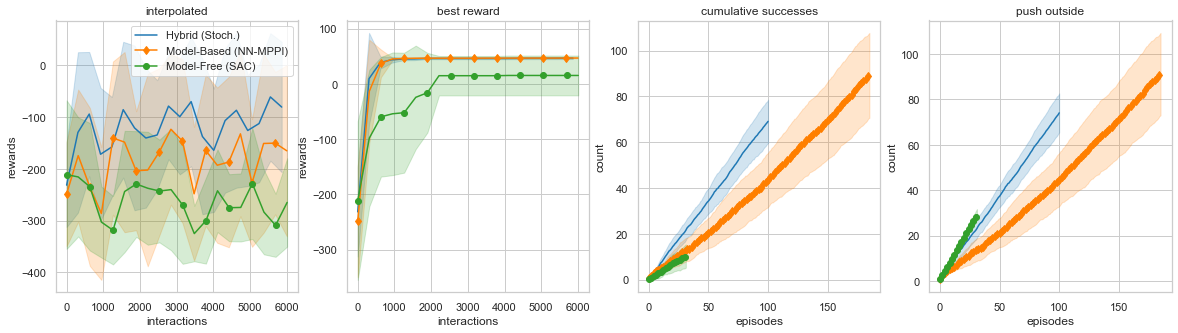

In [14]:
# plot data
plt_colors = ['tab:blue','tab:orange','tab:green']
plt_titles = ['interpolated','best reward','cumulative successes','push outside']
plt_legend = ['Hybrid (Stoch.)','Model-Based (NN-MPPI)','Model-Free (SAC)']

fig, axs = plt.subplots(1,4, figsize=(20,5))
num_trials = 0
for i,(x_samples,data,success,best_data,push,color_idx,marker) in enumerate(zip(all_x, all_data, all_success,all_best_data,all_push,color_idxs,markers)):
    try:
        args = {'label':plt_legend[i],'color':colors[color_idx],'marker':marker}
        plot_data(axs[0],x_samples,data,**args)
        plot_data(axs[1],x_samples,best_data,**args)
        plot_data(axs[2],None,success,**args)
        plot_data(axs[3],None,push,**args)
    except: 
        pass
axs[0].legend()
for i in range(4):
#     axs[i].legend()
    if i < 2: 
        axs[i].set_xlabel('interactions')
        axs[i].set_ylabel('rewards')
    else: 
        axs[i].set_xlabel('episodes')
        axs[i].set_ylabel('count')
#         axs[i].set_xlim([0,100])
    axs[i].set_title(plt_titles[i])
# axs[2].legend(ncol=3)
# axs[2].set_title(plt_titles[2])
# print('{} trials each'.format(num_trials+1))
# plt.savefig('sawyer-clutter.pdf')
# axs[0].set_xlim(0, 20000)


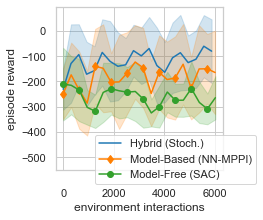

In [17]:
# plot data
fig, axs = plt.subplots(1,1, figsize=(3,3))
num_trials = 0
for i,(x_samples,data,success,best_data,color_idx,marker) in enumerate(zip(all_x, all_data, all_success,all_best_data,color_idxs,markers)):
    try:
        args = {'label':plt_legend[i],'color':colors[color_idx],'marker':marker}
        plot_data(axs,x_samples,data,**args,std_scale=1.0)
    except: 
        pass
axs.set_xlabel('environment interactions')
axs.set_ylabel('episode reward')
# axs.set_title('Sawyer Clutter')
# axs.set_ylim([-450,198])
# axs.legend(bbox_to_anchor=(0.2,1.15),loc=2)
axs.set_ylim([-550,95])
axs.tick_params(axis='x', pad=13)
axs.legend(bbox_to_anchor=(0.2,.25),loc=2)
# axs.grid()
# plt.suptitle('{} trials each'.format(num_trials),fontsize=12)
plt.savefig('sawyer-clutter.pdf', bbox_inches='tight')
# axs[0].set_xlim(0, 20000)